Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading dataset...
Previewing the dataset:
                                                text  generated
0  Cars. Cars have been around since they became ...          0
1  Transportation is a large necessity in most co...          0
2  "America's love affair with it's vehicles seem...          0
3  How often do you ride in a car? Do you drive a...          0
4  Cars are a wonderful thing. They are perhaps o...          0
Starting parallel text cleaning...
Text cleaning completed.
Encoding labels...
Extracting features using TF-IDF...
Splitting the dataset into training and testing sets...
Training the MLP model...
Iteration 1, loss = 0.16138786
Iteration 2, loss = 0.02299943
Iteration 3, loss = 0.01057736
Iteration 4, loss = 0.00624236
Iteration 5, loss = 0.00429100
Iteration 6, loss = 0.00331517
Iteration 7, loss = 0.00275097
Iteration 8, loss = 0.00239066
Iteration 9, loss = 0.00214394
Iteration 10, loss = 0.00196256
Iteration 11, loss = 0.00182132
Iteration 12, loss = 0.00170621
I

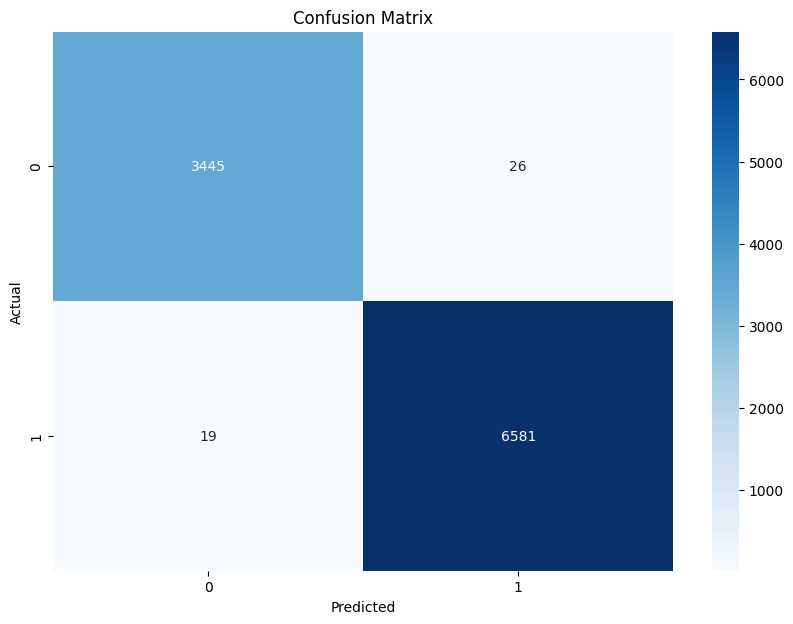

Saving the MLP model to /content/drive/My Drive/mlp_model.pkl...
Model saved successfully.


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from concurrent.futures import ThreadPoolExecutor

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Download NLTK data
print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset
print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/AI_Human.csv')  # Ensure the file path is correct

# Preview the dataset
print("Previewing the dataset:")
print(df.head())

# Text cleaning function
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove all non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    return text

# Tokenization and removing stopwords
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Define a function for parallel text cleaning using multi-threading
def parallel_cleaning(df):
    print("Starting parallel text cleaning...")
    num_workers = os.cpu_count()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        df['text'] = list(executor.map(clean_text, df['text']))
        df['text'] = list(executor.map(tokenize_and_remove_stopwords, df['text']))
    print("Text cleaning completed.")
    return df

# Apply parallel text cleaning
df = parallel_cleaning(df)

# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
df['generated'] = label_encoder.fit_transform(df['generated'])

# Feature extraction using TF-IDF
print("Extracting features using TF-IDF...")
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['text'])
y = df['generated']

# Split the dataset into training and testing sets
print("Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the MLP model
print("Training the MLP model...")
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, verbose=True, tol=1e-4, n_iter_no_change=50)
mlp_classifier.fit(X_train, y_train)

# Evaluate the model
print("Evaluating the MLP model...")
y_pred = mlp_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Plot confusion matrix
print("Plotting confusion matrix...")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the model to Google Drive
model_path = '/content/drive/My Drive/mlp_model.pkl'
print(f"Saving the MLP model to {model_path}...")
with open(model_path, 'wb') as f:
    pickle.dump(mlp_classifier, f)

print("Model saved successfully.")
